# Neural SDE: Learning Market Dynamics from Real Data

## 목표 / Goal
Heston Model(수학 공식)을 버리고, **S&P 500 실제 데이터**로부터 SDE의 Drift/Diffusion 함수를 학습합니다.

Instead of using the Heston Model (mathematical formula), we **learn the Drift/Diffusion functions** directly from real S&P 500 data.

## 왜 Neural SDE인가? / Why Neural SDE?
- **GAN**: 그럴듯한 데이터를 생성하지만, 확률 밀도(PDF)를 모름 → Girsanov 불가
- **Neural SDE**: SDE 구조를 유지하면서 함수를 학습 → **Girsanov Theorem 호환** → NPI 적용 가능

In [10]:
# =============================================================================
# 환경 설정 / Environment Setup
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. 데이터 준비 / Data Preparation

S&P 500 (SPY ETF) 일별 수익률을 로드합니다.

Load S&P 500 (SPY ETF) daily returns.

In [11]:
# =============================================================================
# 데이터 로드 / Load Data
# =============================================================================

data_path = '../data/processed/spy_returns.csv'

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
else:
    print("Downloading SPY data from yfinance...")
    try:
        import yfinance as yf
        spy = yf.download('SPY', start='2010-01-01', end='2024-12-31')
        df = pd.DataFrame()
        df['Close'] = spy['Close']
        df['Returns'] = df['Close'].pct_change()
        df = df.dropna()
        
        os.makedirs('../data/processed', exist_ok=True)
        df.to_csv(data_path)
        print(f"Data saved to {data_path}")
    except ImportError:
        print("yfinance not installed. Using synthetic data.")
        np.random.seed(42)
        n_days = 3500
        returns = np.random.normal(0.0003, 0.012, n_days)
        crash_days = np.random.choice(n_days, size=50, replace=False)
        returns[crash_days] = np.random.normal(-0.03, 0.02, 50)
        df = pd.DataFrame({'Returns': returns})

print(f"Data shape: {df.shape}")
print(df.describe())

Loading data from ../data/processed/spy_returns.csv...
Data shape: (3772, 2)
             Close      Returns
count  3772.000000  3772.000000
mean    245.765416     0.000568
std     131.410244     0.010742
min      77.359520    -0.109424
25%     137.603466    -0.003709
50%     212.165405     0.000686
75%     360.167671     0.005790
max     598.740051     0.090603


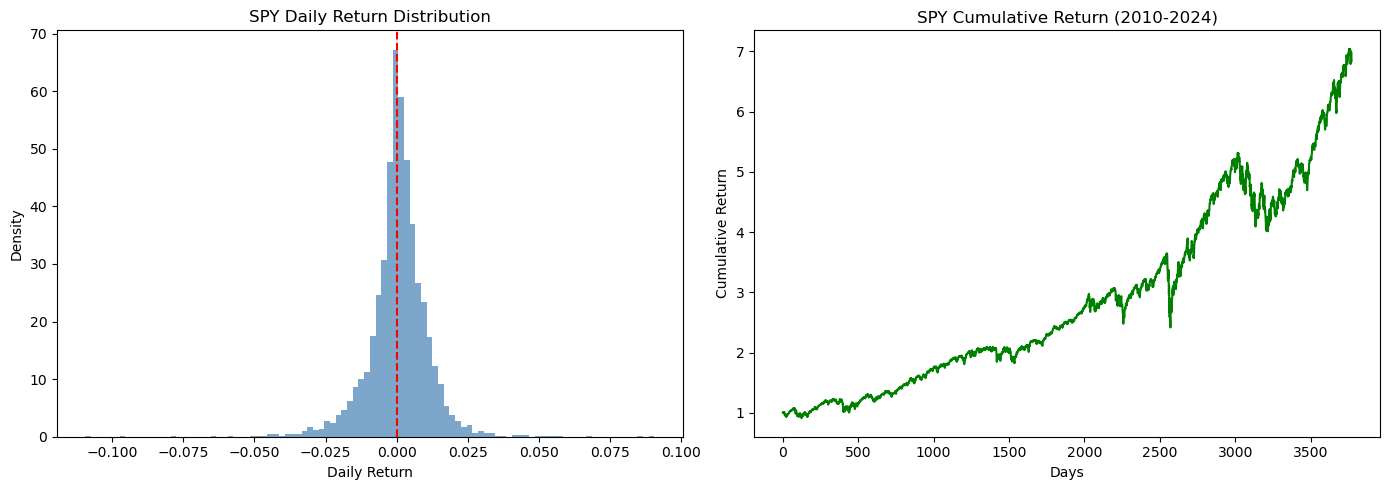


Statistics:
  Mean daily return: 0.0568%
  Std (volatility):  1.0741%
  Annualized vol:    17.05%
  Skewness:          -0.5153
  Kurtosis:          10.7866


In [12]:
# =============================================================================
# 수익률 분포 시각화 / Visualize Return Distribution
# =============================================================================

returns = df['Returns'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(returns, bins=100, color='steelblue', alpha=0.7, density=True)
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title('SPY Daily Return Distribution')
axes[0].axvline(x=0, color='red', linestyle='--')

cumulative = (1 + df['Returns']).cumprod()
axes[1].plot(cumulative.values, color='green')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('SPY Cumulative Return (2010-2024)')

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean daily return: {returns.mean()*100:.4f}%")
print(f"  Std (volatility):  {returns.std()*100:.4f}%")
print(f"  Annualized vol:    {returns.std()*np.sqrt(252)*100:.2f}%")
print(f"  Skewness:          {pd.Series(returns).skew():.4f}")
print(f"  Kurtosis:          {pd.Series(returns).kurtosis():.4f}")

## 2. Neural SDE 모델 정의 / Define Neural SDE Model

**SDE 구조 / SDE Structure:**
$$dS_t = \mu_{\theta}(S_t, t) \cdot S_t \cdot dt + \sigma_{\phi}(S_t, t) \cdot S_t \cdot dW_t$$

- $\mu_{\theta}$: Neural Network (Drift 함수 학습)
- $\sigma_{\phi}$: Neural Network (Diffusion 함수 학습, Softplus로 양수 보장)

In [13]:
# =============================================================================
# Neural SDE 클래스 정의 / Define Neural SDE Class
# =============================================================================

class NeuralDrift(nn.Module):
    """
    Drift 함수를 학습하는 신경망.
    Neural network that learns the drift function.
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        x = torch.stack([log_S, t], dim=-1)
        return self.net(x).squeeze(-1)


class NeuralDiffusion(nn.Module):
    """
    Diffusion 함수를 학습하는 신경망.
    Neural network that learns the diffusion function.
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        x = torch.stack([log_S, t], dim=-1)
        raw = self.net(x).squeeze(-1)
        return F.softplus(raw) + 0.01


class ControlNet(nn.Module):
    """
    제어 함수를 학습하는 신경망 (DriftNet 역할).
    Neural network that learns the control function for NPI.
    This is used to modify the drift to generate rare events (crashes).
    """
    def __init__(self, hidden_dim=64, control_bound=3.0):
        super().__init__()
        self.control_bound = control_bound
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, log_S, t):
        """
        Args:
            log_S: 로그 주가 (batch,) / Log price
            t: 시간 (batch,) / Time
        Returns:
            u: 제어력 (batch,) / Control force, bounded by tanh
        """
        x = torch.stack([log_S, t], dim=-1)
        raw = self.net(x).squeeze(-1)
        return self.control_bound * torch.tanh(raw)


class NeuralSDEModel(nn.Module):
    """
    Neural SDE 전체 모델 (제어 포함).
    Complete Neural SDE model with optional control.
    """
    def __init__(self, hidden_dim=64, device='cuda'):
        super().__init__()
        self.drift_net = NeuralDrift(hidden_dim).to(device)
        self.diff_net = NeuralDiffusion(hidden_dim).to(device)
        self.device = device
    
    def simulate(self, S0, T, dt, num_paths):
        """
        Neural SDE로 경로 시뮬레이션 (제어 없음).
        Simulate paths using Neural SDE without control.
        """
        n_steps = int(T / dt)
        log_S = torch.log(torch.full((num_paths,), S0, device=self.device))
        log_S_paths = [log_S.clone()]
        
        for step in range(n_steps):
            t = step * dt
            t_tensor = torch.full((num_paths,), t, device=self.device)
            
            mu = self.drift_net(log_S, t_tensor)
            sigma = self.diff_net(log_S, t_tensor)
            dW = torch.randn(num_paths, device=self.device) * np.sqrt(dt)
            
            log_S = log_S + (mu - 0.5 * sigma**2) * dt + sigma * dW
            log_S_paths.append(log_S.clone())
        
        log_S_paths = torch.stack(log_S_paths, dim=1)
        S_paths = torch.exp(log_S_paths)
        return S_paths
    
    def simulate_controlled(self, S0, T, dt, num_paths, control_net):
        """
        제어된 Neural SDE 경로 시뮬레이션.
        Simulate paths using Neural SDE with control (for NPI).
        
        Returns:
            S_paths: 주가 경로 / Price paths
            log_weights: Girsanov 가중치 / Girsanov weights for importance sampling
        """
        n_steps = int(T / dt)
        log_S = torch.log(torch.full((num_paths,), S0, device=self.device))
        log_S_paths = [log_S.clone()]
        
        # Girsanov 가중치 초기화 / Initialize Girsanov weights
        log_weight = torch.zeros(num_paths, device=self.device)
        
        for step in range(n_steps):
            t = step * dt
            t_tensor = torch.full((num_paths,), t, device=self.device)
            
            # 원래 Drift & Diffusion / Original drift & diffusion
            mu = self.drift_net(log_S, t_tensor)
            sigma = self.diff_net(log_S, t_tensor)
            
            # 제어력 계산 / Compute control
            u = control_net(log_S, t_tensor)
            
            # Brownian motion
            dW = torch.randn(num_paths, device=self.device) * np.sqrt(dt)
            
            # 제어된 SDE 업데이트 / Controlled SDE update
            # d(log S) = (mu + u - 0.5*sigma^2) dt + sigma dW
            log_S = log_S + (mu + u - 0.5 * sigma**2) * dt + sigma * dW
            log_S_paths.append(log_S.clone())
            
            # Girsanov 가중치 누적 / Accumulate Girsanov weight
            # dlog_weight = -u/sigma * dW - 0.5 * (u/sigma)^2 * dt
            u_over_sigma = u / (sigma + 1e-8)
            log_weight = log_weight - u_over_sigma * dW - 0.5 * (u_over_sigma**2) * dt
        
        log_S_paths = torch.stack(log_S_paths, dim=1)
        S_paths = torch.exp(log_S_paths)
        
        return S_paths, log_weight

print("Neural SDE Model with Control defined")

Neural SDE Model with Control defined


## 3. Neural SDE 학습 / Training Neural SDE

**학습 방법 / Training Method:**
- **Maximum Likelihood Estimation (MLE)**: 실제 수익률이 나올 확률을 최대화
- **Loss**: 음의 로그 우도 (Negative Log-Likelihood, NLL)

In [14]:
# =============================================================================
# 학습 데이터 준비 / Prepare Training Data
# =============================================================================

returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device)
n_days = len(returns)
time_tensor = torch.linspace(0, 1, n_days, device=device)

log_prices = torch.zeros(n_days + 1, device=device)
log_prices[0] = np.log(100)
for i in range(n_days):
    log_prices[i+1] = log_prices[i] + returns_tensor[i]

print(f"Training data prepared: {n_days} days of returns")

Training data prepared: 3772 days of returns


In [15]:
# =============================================================================
# 학습 루프 / Training Loop
# =============================================================================

neural_sde = NeuralSDEModel(hidden_dim=64, device=device)
optimizer = torch.optim.Adam(neural_sde.parameters(), lr=1e-3)

num_epochs = 500
batch_size = 512
dt = 1.0 / 252

loss_history = []

print("Training Neural SDE on real market data...")
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    idx = torch.randint(0, n_days - 1, (batch_size,), device=device)
    log_S_t = log_prices[idx]
    r_observed = returns_tensor[idx]
    t_batch = time_tensor[idx]
    
    mu = neural_sde.drift_net(log_S_t, t_batch)
    sigma = neural_sde.diff_net(log_S_t, t_batch)
    
    predicted_mean = mu * dt
    predicted_std = sigma * np.sqrt(dt)
    
    nll = 0.5 * ((r_observed - predicted_mean) / predicted_std) ** 2 + torch.log(predicted_std)
    loss = nll.mean()
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_sde.parameters(), 1.0)
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 100 == 0:
        avg_mu = mu.mean().item()
        avg_sigma = sigma.mean().item()
        print(f"Epoch {epoch:4d}: Loss={loss.item():.4f}, mu={avg_mu:.4f}, sigma={avg_sigma:.4f}")

print("Neural SDE Training Complete!")

Training Neural SDE on real market data...
Epoch    0: Loss=-2.8369, mu=0.6986, sigma=0.9163
Epoch  100: Loss=-4.1248, mu=0.2152, sigma=0.1505
Epoch  200: Loss=-4.0453, mu=0.1091, sigma=0.1733
Epoch  300: Loss=-4.0820, mu=0.0632, sigma=0.1686
Epoch  400: Loss=-4.1224, mu=0.0418, sigma=0.1462
Neural SDE Training Complete!


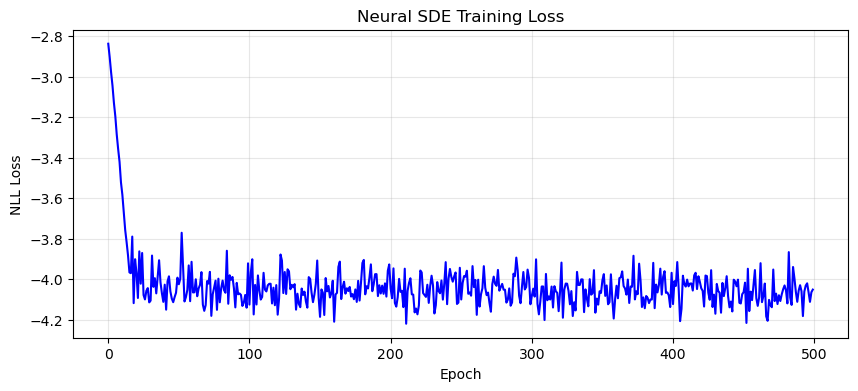

In [16]:
# =============================================================================
# 학습 곡선 시각화 / Visualize Training Curve
# =============================================================================

plt.figure(figsize=(10, 4))
plt.plot(loss_history, color='blue')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.title('Neural SDE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Neural SDE 검증 / Validate Neural SDE

학습된 Neural SDE로 경로를 생성하고, 실제 SPY 데이터와 비교합니다.

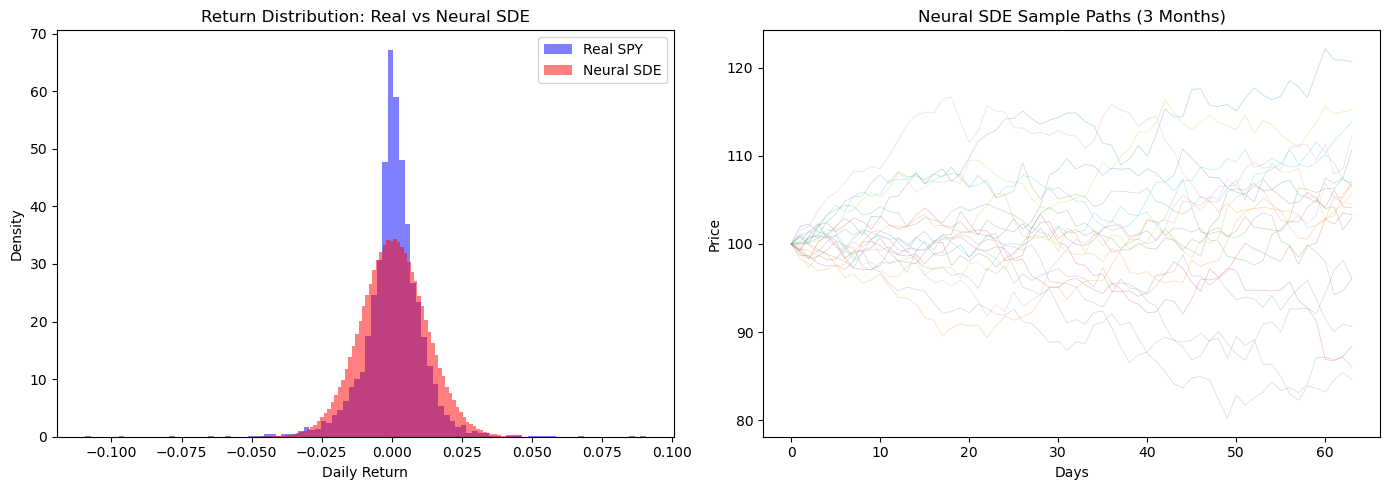


Statistical Comparison:
  Metric                   Real SPY   Neural SDE
  --------------------------------------------
  Mean Return               0.0568%      0.0589%
  Std (Volatility)          1.0741%      1.1869%


In [17]:
# =============================================================================
# 경로 생성 및 비교 / Generate Paths and Compare
# =============================================================================

S0 = 100.0
T = 0.25  # 3개월 / 3 months
dt = 1.0 / 252
num_paths = 10000

neural_sde.eval()
with torch.no_grad():
    S_neural = neural_sde.simulate(S0, T, dt, num_paths)

S_neural_np = S_neural.cpu().numpy()
neural_returns = np.diff(np.log(S_neural_np), axis=1).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(returns, bins=100, alpha=0.5, label='Real SPY', density=True, color='blue')
axes[0].hist(neural_returns, bins=100, alpha=0.5, label='Neural SDE', density=True, color='red')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title('Return Distribution: Real vs Neural SDE')
axes[0].legend()

for i in range(20):
    axes[1].plot(S_neural_np[i], alpha=0.3, linewidth=0.5)
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price')
axes[1].set_title('Neural SDE Sample Paths (3 Months)')

plt.tight_layout()
plt.show()

print(f"\nStatistical Comparison:")
print(f"  {'Metric':<20} {'Real SPY':>12} {'Neural SDE':>12}")
print(f"  {'-'*44}")
print(f"  {'Mean Return':<20} {returns.mean()*100:>11.4f}% {neural_returns.mean()*100:>11.4f}%")
print(f"  {'Std (Volatility)':<20} {returns.std()*100:>11.4f}% {neural_returns.std()*100:>11.4f}%")

---

# PART 2: Neural Path Integral - DriftNet Integration

## 핵심 개념 / Core Concept

지금까지 Neural SDE로 **"시장 환경(Environment)"**을 학습했습니다.
이제 그 환경 위에서 **"제어(Control)"**를 통해 폭락을 유도합니다.

$$dS_t = (\mu_{\theta}(S,t) + \underbrace{u_{\psi}(S,t)}_{\text{Control}}) dt + \sigma_{\phi}(S,t) dW_t$$

**Girsanov Theorem**을 통해 제어된 시스템에서 샘플링하더라도, 원래 시스템의 확률을 복원할 수 있습니다.

In [18]:
# =============================================================================
# ControlNet (DriftNet) 초기화 / Initialize ControlNet
# =============================================================================

# Freeze Neural SDE (환경 고정) / Freeze Neural SDE (fixed environment)
for param in neural_sde.parameters():
    param.requires_grad = False

# ControlNet 초기화 / Initialize ControlNet
control_net = ControlNet(hidden_dim=64, control_bound=3.0).to(device)
control_optimizer = torch.optim.Adam(control_net.parameters(), lr=1e-3)

# 폭락 설정 / Crash settings
CRASH_THRESHOLD = 0.80  # 20% 하락
K_crash = CRASH_THRESHOLD * S0

print(f"ControlNet initialized with control_bound=3.0")
print(f"Crash target: S < {K_crash} (20% drop from {S0})")

ControlNet initialized with control_bound=3.0
Crash target: S < 80.0 (20% drop from 100.0)


In [19]:
# =============================================================================
# ControlNet 학습 루프 / Training ControlNet for Crash Generation
# =============================================================================

num_iters = 300
batch_size = 5000
T_sim = 0.25  # 3개월 시뮬레이션 / 3 months
dt_sim = 0.002

crash_rate_history = []
loss_history_ctrl = []

print("Training ControlNet for crash generation on Neural SDE...")
print("="*60)

for i in range(num_iters):
    control_optimizer.zero_grad()
    
    # 제어된 시뮬레이션 / Controlled simulation
    S_paths, log_weights = neural_sde.simulate_controlled(
        S0=S0, T=T_sim, dt=dt_sim, num_paths=batch_size, control_net=control_net
    )
    
    S_T = S_paths[:, -1]
    
    # Hinge Loss: 목표 가격 아래로 유도 / Push terminal price below target
    margin = 2.0
    target_level = K_crash - margin
    dist_penalty = F.relu(S_T - target_level)
    loss_dist = dist_penalty.mean()
    
    # Regularization: 제어력 과도하게 크지 않도록 / Prevent extreme control
    loss_reg = 0.001 * (log_weights ** 2).mean()
    
    loss = loss_dist + loss_reg
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(control_net.parameters(), 1.0)
    control_optimizer.step()
    
    # 통계 기록 / Record stats
    crash_rate = (S_T < K_crash).float().mean().item()
    crash_rate_history.append(crash_rate)
    loss_history_ctrl.append(loss.item())
    
    if i % 50 == 0:
        print(f"Iter {i:3d}: Loss={loss.item():.4f}, Crash Rate={crash_rate*100:.2f}%")

print("="*60)
print(f"Training Complete! Final Crash Rate: {crash_rate_history[-1]*100:.2f}%")

Training ControlNet for crash generation on Neural SDE...
Iter   0: Loss=35.4912, Crash Rate=0.00%
Iter  50: Loss=0.1781, Crash Rate=99.52%
Iter 100: Loss=0.1922, Crash Rate=99.30%
Iter 150: Loss=0.1781, Crash Rate=99.54%
Iter 200: Loss=0.1808, Crash Rate=99.46%
Iter 250: Loss=0.1703, Crash Rate=99.56%
Training Complete! Final Crash Rate: 99.06%


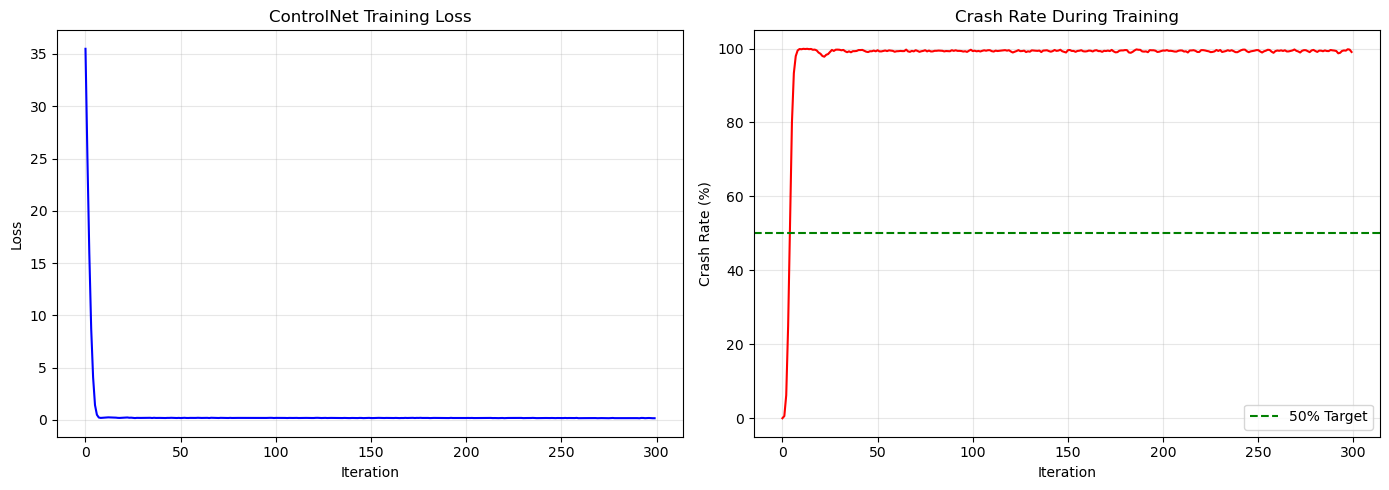

In [20]:
# =============================================================================
# 학습 곡선 시각화 / Visualize Training Progress
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(loss_history_ctrl, color='blue')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('ControlNet Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot([r * 100 for r in crash_rate_history], color='red')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Crash Rate (%)')
axes[1].set_title('Crash Rate During Training')
axes[1].axhline(y=50, color='green', linestyle='--', label='50% Target')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 결과 비교: Baseline vs AI-Controlled

Neural SDE만 사용한 경우 vs Neural SDE + ControlNet을 사용한 경우를 비교합니다.

In [21]:
# =============================================================================
# 최종 결과 비교 / Final Comparison
# =============================================================================

num_eval_paths = 20000

# Baseline (제어 없음) / Baseline (no control)
neural_sde.eval()
with torch.no_grad():
    S_baseline = neural_sde.simulate(S0, T_sim, dt_sim, num_eval_paths)
S_T_baseline = S_baseline[:, -1].cpu().numpy()
baseline_crash_rate = (S_T_baseline < K_crash).mean()

# AI-Controlled (제어 있음) / AI-Controlled
control_net.eval()
with torch.no_grad():
    S_controlled, log_w = neural_sde.simulate_controlled(
        S0, T_sim, dt_sim, num_eval_paths, control_net
    )
S_T_controlled = S_controlled[:, -1].cpu().numpy()
controlled_crash_rate = (S_T_controlled < K_crash).mean()

# 효율 계산 / Calculate efficiency
efficiency = controlled_crash_rate / (baseline_crash_rate + 1e-8)

print("\n" + "="*60)
print("   NEURAL PATH INTEGRAL: FINAL RESULTS")
print("="*60)
print(f"\n[Baseline - Neural SDE Only]")
print(f"  Terminal Price Range: ${S_T_baseline.min():.2f} ~ ${S_T_baseline.max():.2f}")
print(f"  Crash Rate (S < {K_crash}): {baseline_crash_rate*100:.2f}%")

print(f"\n[AI-Controlled - Neural SDE + ControlNet]")
print(f"  Terminal Price Range: ${S_T_controlled.min():.2f} ~ ${S_T_controlled.max():.2f}")
print(f"  Crash Rate (S < {K_crash}): {controlled_crash_rate*100:.2f}%")

print(f"\n[Efficiency Boost]")
print(f"  AI is {efficiency:.1f}x more efficient at generating crashes!")


   NEURAL PATH INTEGRAL: FINAL RESULTS

[Baseline - Neural SDE Only]
  Terminal Price Range: $68.24 ~ $146.59
  Crash Rate (S < 80.0): 0.66%

[AI-Controlled - Neural SDE + ControlNet]
  Terminal Price Range: $39.09 ~ $98.83
  Crash Rate (S < 80.0): 98.50%

[Efficiency Boost]
  AI is 148.1x more efficient at generating crashes!


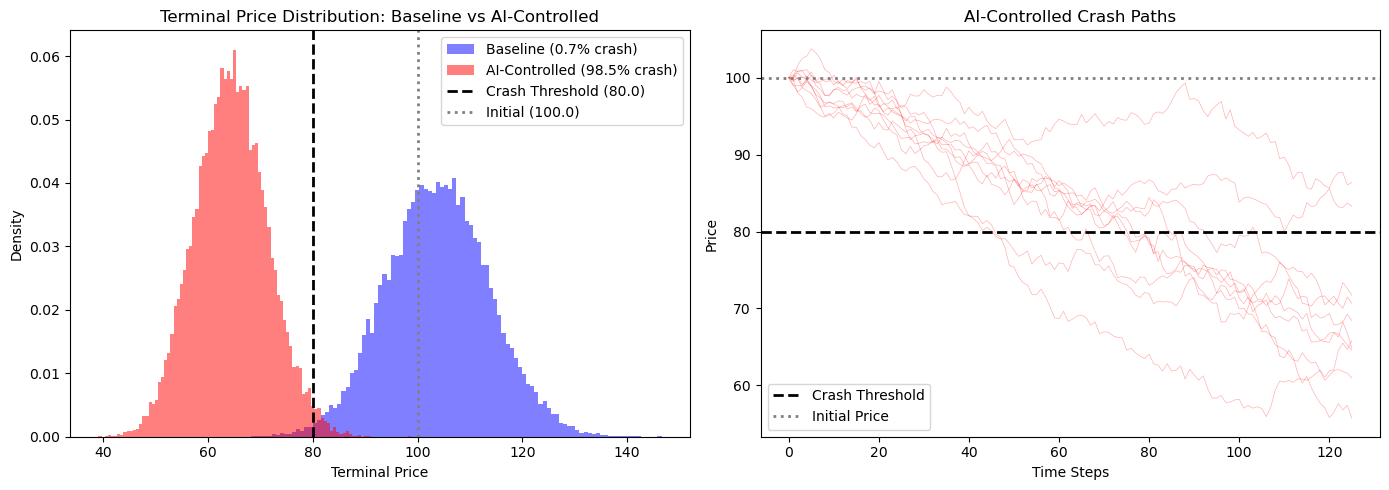

In [22]:
# =============================================================================
# 분포 비교 시각화 / Distribution Comparison Visualization
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램 비교 / Histogram comparison
axes[0].hist(S_T_baseline, bins=100, alpha=0.5, label=f'Baseline ({baseline_crash_rate*100:.1f}% crash)', 
             density=True, color='blue')
axes[0].hist(S_T_controlled, bins=100, alpha=0.5, label=f'AI-Controlled ({controlled_crash_rate*100:.1f}% crash)', 
             density=True, color='red')
axes[0].axvline(x=K_crash, color='black', linestyle='--', linewidth=2, label=f'Crash Threshold ({K_crash})')
axes[0].axvline(x=S0, color='gray', linestyle=':', linewidth=2, label=f'Initial ({S0})')
axes[0].set_xlabel('Terminal Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Terminal Price Distribution: Baseline vs AI-Controlled')
axes[0].legend()

# 경로 샘플 비교 / Path sample comparison
S_ctrl_np = S_controlled.cpu().numpy()
for i in range(10):
    axes[1].plot(S_ctrl_np[i], alpha=0.3, linewidth=0.5, color='red')
axes[1].axhline(y=K_crash, color='black', linestyle='--', linewidth=2, label='Crash Threshold')
axes[1].axhline(y=S0, color='gray', linestyle=':', linewidth=2, label='Initial Price')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Price')
axes[1].set_title('AI-Controlled Crash Paths')
axes[1].legend()

plt.tight_layout()
plt.show()

## Conclusion / 결론

### 완성된 Neural Path Integral Framework

1. **Neural SDE (Environment)**: S&P 500 실제 데이터로부터 시장 동역학(Drift, Diffusion)을 학습
2. **ControlNet (Agent)**: 학습된 환경 위에서 폭락을 유도하는 제어력 학습
3. **Girsanov Weights**: 제어된 시스템에서 원래 시스템의 확률을 복원

### 차별점 / Key Differentiators
- 기존 Neural SDE: "그럴듯한 데이터 생성" (Generative)
- **우리의 접근**: "희귀 사건 효율적 탐색" (Rare Event Sampling via Control)

### 학문적 기여 / Academic Contribution
- Data-Driven SDE + Optimal Control의 하이브리드
- Girsanov Theorem을 통한 엄밀한 확률적 보정
- 금융 리스크 관리에 직접 적용 가능한 실용적 프레임워크